In [1]:
import sys
import warnings
import os
import random
from pathlib import Path
from typing import List, Tuple

sys.path.append("../../")
warnings.filterwarnings("ignore")

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from einops import rearrange
from PIL import Image
from skimage import measure
import rasterio as rio
from torchmetrics.classification import BinaryJaccardIndex, F1Score
from claymodel.finetune.segment.kelp_model import KelpSegmentor  # Your kelp model
from claymodel.finetune.segment.kelp_datamodule import KelpDataset  # Your dataset class
import cv2


### Define paths and parameters

In [3]:
# Model checkpoints
KELP_CHECKPOINT_PATH = r"C:\clay\clay-model\checkpoints\kelp_segment\kelp-binary-segment_epoch-99_val-iou-0.6286.ckpt"
CLAY_CHECKPOINT_PATH = r"C:\clay\clay-model\checkpoints\clay-v1.5.ckpt"
# Data directory containing folders with images and masks
DATA_ROOT = r"C:\Annotated Dataset\L2A Data\Tiles10and20mbandsSubsBathy_G0Percent_stride256"

# Normalization parameters (user-provided)  This needs to be set based on the bands selceted in KelpDataset class, load_image method
# The bands order in the dataset: B2,B3,B4,B8,B5,B6,B7,B8A,B11,B12,Substrate,Bathymetry
# For the selected bands, the user needs to provide mean and std values. Use the notebook calculate_mean_std.ipynb
NORMALIZATION_PARAMS = {
    'mean': [1.92710564e+02, 2.45262772e+02, 1.32882966e+02, 9.15828301e+02, 2.98188553e+02],  # 5 bands: B2,B3,B4,B8,B5
    'std': [1.51370010e+02, 2.08243277e+02, 1.94224862e+02, 1.24217269e+03, 3.68341824e+02]   # 5 bands: B2,B3,B4,B8,B5
}

# Test folder indices - USER CONFIGURABLE
TEST_INDICES = [6]  # Use whatever indices you want here e.g [9,1,3]

# Other parameters
BATCH_SIZE = 8
NUM_WORKERS = 4
TARGET_SIZE = 512
THRESHOLD = 0.5



### Data Preparation Functions

In [4]:
def get_files_from_folders(folders: List[str]) -> Tuple[List[str], List[str]]:
    """
    Get all image and mask file paths from specified folders.
    
    Args:
        folders: List of folder names to process
        
    Returns:
        Tuple of (image_paths, mask_paths)
    """
    data_root = Path(DATA_ROOT)
    image_paths = []
    mask_paths = []
    
    for folder_name in folders:
        folder_path = data_root / folder_name
        images_dir = folder_path / "images"
        masks_dir = folder_path / "masks"
        
        if not images_dir.exists() or not masks_dir.exists():
            print(f"Warning: Skipping {folder_name} - missing images or masks directory")
            continue
        
        # Get all image files
        image_files = list(images_dir.glob("*.tiff")) + list(images_dir.glob("*.tif"))
        
        for image_path in image_files:
            # Find corresponding mask
            image_name = image_path.stem
            # Try different mask naming patterns
            possible_mask_names = [
                image_name.replace("_image", "_mask"),
                image_name.replace("image", "mask"),
                image_name + "_mask",
                image_name,  # Same name different folder
            ]
            
            mask_path = None
            for mask_name in possible_mask_names:
                potential_mask = masks_dir / f"{mask_name}.tiff"
                if potential_mask.exists():
                    mask_path = potential_mask
                    break
                potential_mask = masks_dir / f"{mask_name}.tif"
                if potential_mask.exists():
                    mask_path = potential_mask
                    break
            
            if mask_path is not None:
                image_paths.append(str(image_path))
                mask_paths.append(str(mask_path))
            else:
                print(f"Warning: No mask found for {image_path}")
    
    return image_paths, mask_paths


### Data Split Setup

In [5]:
# Get all available folders
data_root = Path(DATA_ROOT)
folders = [f.name for f in data_root.iterdir() if f.is_dir()]
folders.sort()  # For reproducibility

print(f"Available folders: {folders}")
print(f"Total folders: {len(folders)}")

# Use data from a few folders for testing and shuffle the rest for tr and val (80-20)
# --- Step 1: Assign test folders ---
if len(folders) < 2:
    raise ValueError("At least 2 folders are required to assign one for testing.")

test_indices = TEST_INDICES  # Use whatever indices you want here eg [9,1,3]
test_folders = [folders[i] for i in test_indices]

# Get image/mask paths for test folders
X_test_paths, y_test_paths = get_files_from_folders(test_folders)

# Exclude the actual test folders from train/val
train_val_folders = [f for i, f in enumerate(folders) if i not in test_indices]

# Gather all image/mask file paths from remaining folders
X_all_paths, y_all_paths = get_files_from_folders(train_val_folders)

# --- Step 3: Shuffle the image/mask files together (zip to keep them aligned) ---
combined = list(zip(X_all_paths, y_all_paths))
random.seed(42)
random.shuffle(combined)
X_all_paths[:], y_all_paths[:] = zip(*combined)

# --- Step 4: Split 80% for training, 20% for validation ---
split_idx = int(0.8 * len(X_all_paths))
X_train_paths = X_all_paths[:split_idx]
y_train_paths = y_all_paths[:split_idx]
X_val_paths = X_all_paths[split_idx:]
y_val_paths = y_all_paths[split_idx:]

# --- Reporting ---
print(f"Train samples: {len(X_train_paths)}")
print(f"Validation samples: {len(X_val_paths)}")
print(f"Test samples: {len(X_test_paths)}")

# --- Sanity check ---
if len(X_train_paths) != len(y_train_paths) or \
   len(X_val_paths) != len(y_val_paths) or \
   len(X_test_paths) != len(y_test_paths):
    raise ValueError("Mismatch in image and mask counts in one or more splits.")

print(f"\nTest folder(s): {test_folders}")
print(f"Train/Val folders: {train_val_folders}")

Available folders: ['20200908T192939_20200908T193355_T09UWS', '20200908T192939_20200908T193355_T09UXR', '20210727T191911_20210727T192721_T09UXQ', '20220806T191919_20220806T192707_T09UYQ', '20220806T191919_20220806T192707_T10UCU', '20230804T192909_20230804T192942_T09UXS', '20230816T191911_20230816T192348_T10UCA', '20230819T192911_20230819T193100_T09UWT', '20230902T190921_20230902T191805_T10UDU', '20230902T195919_20230902T195917_T09UUU']
Total folders: 10
Train samples: 712
Validation samples: 179
Test samples: 71

Test folder(s): ['20230816T191911_20230816T192348_T10UCA']
Train/Val folders: ['20200908T192939_20200908T193355_T09UWS', '20200908T192939_20200908T193355_T09UXR', '20210727T191911_20210727T192721_T09UXQ', '20220806T191919_20220806T192707_T09UYQ', '20220806T191919_20220806T192707_T10UCU', '20230804T192909_20230804T192942_T09UXS', '20230819T192911_20230819T193100_T09UWT', '20230902T190921_20230902T191805_T10UDU', '20230902T195919_20230902T195917_T09UUU']


### Model Loading

In [6]:
import torch
import gc
import os

def check_gpu_memory():
    """Check and print current GPU memory usage"""
    if torch.cuda.is_available():
        allocated = torch.cuda.memory_allocated() / 1024**3  # GB
        reserved = torch.cuda.memory_reserved() / 1024**3    # GB
        total = torch.cuda.get_device_properties(0).total_memory / 1024**3  # GB
        print(f"GPU Memory - Allocated: {allocated:.2f}GB, Reserved: {reserved:.2f}GB, Total: {total:.2f}GB")
        return allocated, reserved, total
    return 0, 0, 0

def clear_gpu_memory():
    """Aggressive GPU memory cleanup"""
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.ipc_collect()
        torch.cuda.synchronize()
    gc.collect()

def load_kelp_model_gpu_optimized(kelp_checkpoint_path, clay_checkpoint_path):
    """
    GPU-optimized loading that prevents memory crashes
    """
    print("=== GPU-Optimized Model Loading ===")
    
    # Initial cleanup
    clear_gpu_memory()
    check_gpu_memory()
    
    # Step 1: Load checkpoint metadata only
    print("\n1. Loading checkpoint metadata...")
    checkpoint_keys = []
    hparams = {}
    
    # Load just the keys first to see what we're dealing with
    checkpoint = torch.load(kelp_checkpoint_path, map_location='cpu')
    checkpoint_keys = list(checkpoint.keys())
    if 'hyper_parameters' in checkpoint:
        hparams = checkpoint['hyper_parameters'].copy()
    
    print(f"Checkpoint keys: {checkpoint_keys}")
    print(f"Hyperparameters: {hparams}")
    
    # Clean hyperparameters
    clean_hparams = {
        'num_classes': 1,  # Binary segmentation - add this manually
        'ckpt_path': clay_checkpoint_path,
        'lr': hparams.get('lr', 1e-4),  # Match your default
        'wd': hparams.get('wd', 0.05),
        'b1': hparams.get('b1', 0.9),
        'b2': hparams.get('b2', 0.95),
        'threshold': hparams.get('threshold', 0.5),
    }
    
    # Step 2: Create model on CPU first
    print("\n2. Creating model on CPU...")
    clear_gpu_memory()
    
    # Set environment variables for better memory management
    os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'max_split_size_mb:128'
    
    model = KelpSegmentor(**clean_hparams)
    print("✓ Model created on CPU")
    
    # Step 3: Load weights on CPU
    print("\n3. Loading weights on CPU...")
    if 'state_dict' in checkpoint:
        missing_keys, unexpected_keys = model.load_state_dict(
            checkpoint['state_dict'], strict=False
        )
        print(f"✓ Weights loaded. Missing: {len(missing_keys)}, Unexpected: {len(unexpected_keys)}")
    
    # Clean up checkpoint from memory immediately
    del checkpoint
    clear_gpu_memory()
    
    model.eval()
    
    # Step 4: Move to GPU in stages
    print("\n4. Moving to GPU...")
    check_gpu_memory()
    
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    try:
        # Move model to GPU
        model = model.to(device)
        print(f"✓ Model moved to {device}")
        
        # Check final memory usage
        check_gpu_memory()
        
        return model
        
    except RuntimeError as e:
        if "out of memory" in str(e).lower():
            print(f"❌ GPU out of memory: {e}")
            print("Trying with CPU inference...")
            clear_gpu_memory()
            model = model.cpu()
            return model
        else:
            raise e

def load_model_minimal_memory(kelp_checkpoint_path, clay_checkpoint_path):
    """
    Minimal memory approach - load only what's necessary
    """
    print("=== Minimal Memory Loading ===")
    clear_gpu_memory()
    
    # Create model with minimal initialization
    print("Creating minimal model...")
    
    # Use a simple approach - create model and load weights
    model = KelpSegmentor(ckpt_path=clay_checkpoint_path,num_classes=1)
    
    # Load checkpoint and extract only state_dict
    print("Loading checkpoint state dict only...")
    checkpoint = torch.load(kelp_checkpoint_path, map_location='cpu')
    
    if 'state_dict' in checkpoint:
        # Load weights with error handling
        try:
            model.load_state_dict(checkpoint['state_dict'], strict=False)
            print("✓ State dict loaded successfully")
        except Exception as e:
            print(f"State dict loading error: {e}")
            # Try to load matching keys only
            model_state = model.state_dict()
            checkpoint_state = checkpoint['state_dict']
            
            filtered_dict = {k: v for k, v in checkpoint_state.items() 
                           if k in model_state and v.size() == model_state[k].size()}
            
            model.load_state_dict(filtered_dict, strict=False)
            print(f"✓ Loaded {len(filtered_dict)} matching parameters")
    
    # Immediate cleanup
    del checkpoint
    clear_gpu_memory()
    
    model.eval()
    
    # Move to GPU carefully
    device = torch.device('cuda')
    try:
        model = model.to(device)
        print(f"✓ Model on {device}")
        check_gpu_memory()
        return model
    except RuntimeError as e:
        print(f"GPU loading failed: {e}")
        return model.cpu()

# Main function to try different approaches
def get_model(kelp_checkpoint_path, clay_checkpoint_path):
    """
    Main loading function with multiple fallback strategies
    """
    strategies = [
        ("GPU Optimized", load_kelp_model_gpu_optimized),
        ("Minimal Memory", load_model_minimal_memory),
    ]
    
    for strategy_name, strategy_func in strategies:
        try:
            print(f"\n{'='*50}")
            print(f"Trying {strategy_name} Loading Strategy")
            print(f"{'='*50}")
            
            model = strategy_func(kelp_checkpoint_path, clay_checkpoint_path)
            
            print(f"\n✅ SUCCESS: {strategy_name} loading worked!")
            check_gpu_memory()
            return model
            
        except Exception as e:
            print(f"\n❌ {strategy_name} failed: {e}")
            clear_gpu_memory()
            continue
    
    raise RuntimeError("All loading strategies failed!")

# Usage:
"""
# Clear any existing GPU memory
clear_gpu_memory()
check_gpu_memory()

# Load model
print("Loading kelp segmentation model...")
model = get_model(KELP_CHECKPOINT_PATH, CLAY_CHECKPOINT_PATH)
print("Model loaded successfully!")

# Check final state
print(f"Model device: {next(model.parameters()).device}")
check_gpu_memory()
"""

'\n# Clear any existing GPU memory\nclear_gpu_memory()\ncheck_gpu_memory()\n\n# Load model\nprint("Loading kelp segmentation model...")\nmodel = get_model(KELP_CHECKPOINT_PATH, CLAY_CHECKPOINT_PATH)\nprint("Model loaded successfully!")\n\n# Check final state\nprint(f"Model device: {next(model.parameters()).device}")\ncheck_gpu_memory()\n'

In [7]:
# Step 3: Full loading (only if step 2 worked)
print("\nStep 3: Full model loading...")
try:
    clear_gpu_memory()
    model = get_model(KELP_CHECKPOINT_PATH, CLAY_CHECKPOINT_PATH)
    print("✅ Full model loading successful!")
    print(f"Final model device: {next(model.parameters()).device}")
    check_gpu_memory()
except Exception as e:
    print(f"❌ Full loading failed: {e}")


Step 3: Full model loading...

Trying GPU Optimized Loading Strategy
=== GPU-Optimized Model Loading ===
GPU Memory - Allocated: 0.00GB, Reserved: 0.00GB, Total: 15.99GB

1. Loading checkpoint metadata...
Checkpoint keys: ['epoch', 'global_step', 'pytorch-lightning_version', 'state_dict', 'loops', 'hparams_name', 'hyper_parameters']
Hyperparameters: {'ckpt_path': 'checkpoints/clay-v1.5.ckpt', 'lr': 1e-05, 'wd': 0.05, 'b1': 0.9, 'b2': 0.95, 'threshold': 0.5, '_instantiator': 'lightning.pytorch.cli.instantiate_module'}

2. Creating model on CPU...
Loaded parameter: cls_token with size torch.Size([1, 1, 1024])
Loaded parameter: patch_embedding.weight_generator.weight_tokens with size torch.Size([128, 128])
Loaded parameter: patch_embedding.weight_generator.bias_token with size torch.Size([1, 128])
Loaded parameter: patch_embedding.weight_generator.encoder.layers.0.self_attn.in_proj_weight with size torch.Size([384, 128])
Loaded parameter: patch_embedding.weight_generator.encoder.layers.0

### Create Test Dataset and DataLoader


In [8]:
# Create test dataset with normalization for model evaluation
test_dataset = KelpDataset(
    data_paths=list(zip(X_test_paths, y_test_paths)),
    normalization_params=NORMALIZATION_PARAMS,
    target_size=TARGET_SIZE,
    augment=False  # No augmentation for testing
)

# Create test dataloader
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    persistent_workers=True
)

print(f"Test dataset created with {len(test_dataset)} samples")
print(f"Test dataloader created with batch size {BATCH_SIZE}")

Dataset initialized with 71 samples
Target size: 512x512
Augmentation: disabled
Using first 5 Sentinel-2 bands: ['B2', 'B3', 'B4', 'B8', 'B5']
Test dataset created with 71 samples
Test dataloader created with batch size 8


### Model Evaluation on Test Set


In [9]:
import torch
import numpy as np
from torchmetrics.classification import BinaryJaccardIndex, BinaryPrecision, BinaryRecall, BinaryF1Score

# Define threshold (assuming THRESHOLD is defined elsewhere, e.g., 0.5)
THRESHOLD = 0.5

# Initialize metrics
# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print(f"Model moved to device: {device}")

# Initialize metrics for kelp class (label 1) on GPU for batch processing
iou_metric = BinaryJaccardIndex(threshold=THRESHOLD).to(device)
precision_metric = BinaryPrecision(threshold=THRESHOLD).to(device)
recall_metric = BinaryRecall(threshold=THRESHOLD).to(device)
f1_metric = BinaryF1Score(threshold=THRESHOLD).to(device)

# Accumulators for dataset-wide metrics
all_preds = []
all_gts = []
all_per_image_ious = []

# Run evaluation
model.eval()
print("Running model evaluation on test set...")
with torch.no_grad():
    for batch_idx, batch in enumerate(test_loader):
        # Move batch to device
        batch = {k: v.to(device) for k, v in batch.items()}

        # Get model predictions (raw logits)
        logits = model(batch)

        # Apply sigmoid to get probabilities
        prob_masks = torch.sigmoid(logits.squeeze(1))  # Remove channel dimension [B, H, W]

        # Apply threshold to get binary predictions
        pred_masks = (prob_masks > THRESHOLD).float()  # [B, H, W]

        # Get ground truth masks
        gt_masks = batch["label"].float()  # [B, H, W]

        # Calculate per-image IoU for the batch
        for i in range(pred_masks.shape[0]):  # Iterate over batch
            iou = iou_metric(pred_masks[i:i+1], gt_masks[i:i+1])  # IoU for single image
            all_per_image_ious.append(iou.item())

        # Accumulate predictions and ground truth for dataset-wide metrics
        all_preds.append(pred_masks.cpu())  # Move to CPU to save GPU memory
        all_gts.append(gt_masks.cpu())

        # Calculate batch metrics for logging
        batch_iou = iou_metric(pred_masks, gt_masks)
        batch_f1 = f1_metric(pred_masks, gt_masks)

        if batch_idx % 2 == 0:
            print(f"Batch {batch_idx}/{len(test_loader)}: IoU={batch_iou:.4f}, F1={batch_f1:.4f}")

# Concatenate all predictions and ground truth for dataset-wide metrics
all_preds = torch.cat(all_preds, dim=0)  # [N, H, W]
all_gts = torch.cat(all_gts, dim=0)  # [N, H, W]

# Move metrics to CPU for dataset-wide computation
iou_metric = iou_metric.to('cpu')
precision_metric = precision_metric.to('cpu')
recall_metric = recall_metric.to('cpu')
f1_metric = f1_metric.to('cpu')

# Calculate dataset-wide metrics for kelp class
kelp_dataset_iou = iou_metric(all_preds, all_gts).item()
kelp_precision = precision_metric(all_preds, all_gts).item()
kelp_recall = recall_metric(all_preds, all_gts).item()
kelp_f1 = f1_metric(all_preds, all_gts).item()
kelp_per_image_iou = np.mean(all_per_image_ious)
kelp_per_image_iou_std = np.std(all_per_image_ious)

# Log metrics
stage = "test"
metrics = {
    f"{stage}_kelp_per_image_iou": kelp_per_image_iou,
    f"{stage}_kelp_per_image_iou_std": kelp_per_image_iou_std,
    f"{stage}_kelp_dataset_iou": kelp_dataset_iou,
    f"{stage}_kelp_precision": kelp_precision,
    f"{stage}_kelp_recall": kelp_recall,
    f"{stage}_kelp_f1_score": kelp_f1,
}

# Print results
print(f"\n=== TEST SET RESULTS ===")
print(f"Kelp Per-Image IoU: {kelp_per_image_iou:.4f} ± {kelp_per_image_iou_std:.4f}")
print(f"Kelp Dataset IoU: {kelp_dataset_iou:.4f}")
print(f"Kelp Precision: {kelp_precision:.4f}")
print(f"Kelp Recall: {kelp_recall:.4f}")
print(f"Kelp F1-Score: {kelp_f1:.4f}")
print(f"Total test samples: {len(test_dataset)}")


Model moved to device: cuda
Running model evaluation on test set...
Batch 0/9: IoU=0.1963, F1=0.3281
Batch 2/9: IoU=0.1225, F1=0.2183
Batch 4/9: IoU=0.0956, F1=0.1745
Batch 6/9: IoU=0.2313, F1=0.3757
Batch 8/9: IoU=0.1769, F1=0.3006

=== TEST SET RESULTS ===
Kelp Per-Image IoU: 0.1266 ± 0.1224
Kelp Dataset IoU: 0.1598
Kelp Precision: 0.7634
Kelp Recall: 0.1682
Kelp F1-Score: 0.2756
Total test samples: 71


### Visualize Test Results

Dataset initialized with 71 samples
Target size: 512x512
Augmentation: disabled
Using first 5 Sentinel-2 bands: ['B2', 'B3', 'B4', 'B8', 'B5']
Visualizing first 9 test samples...


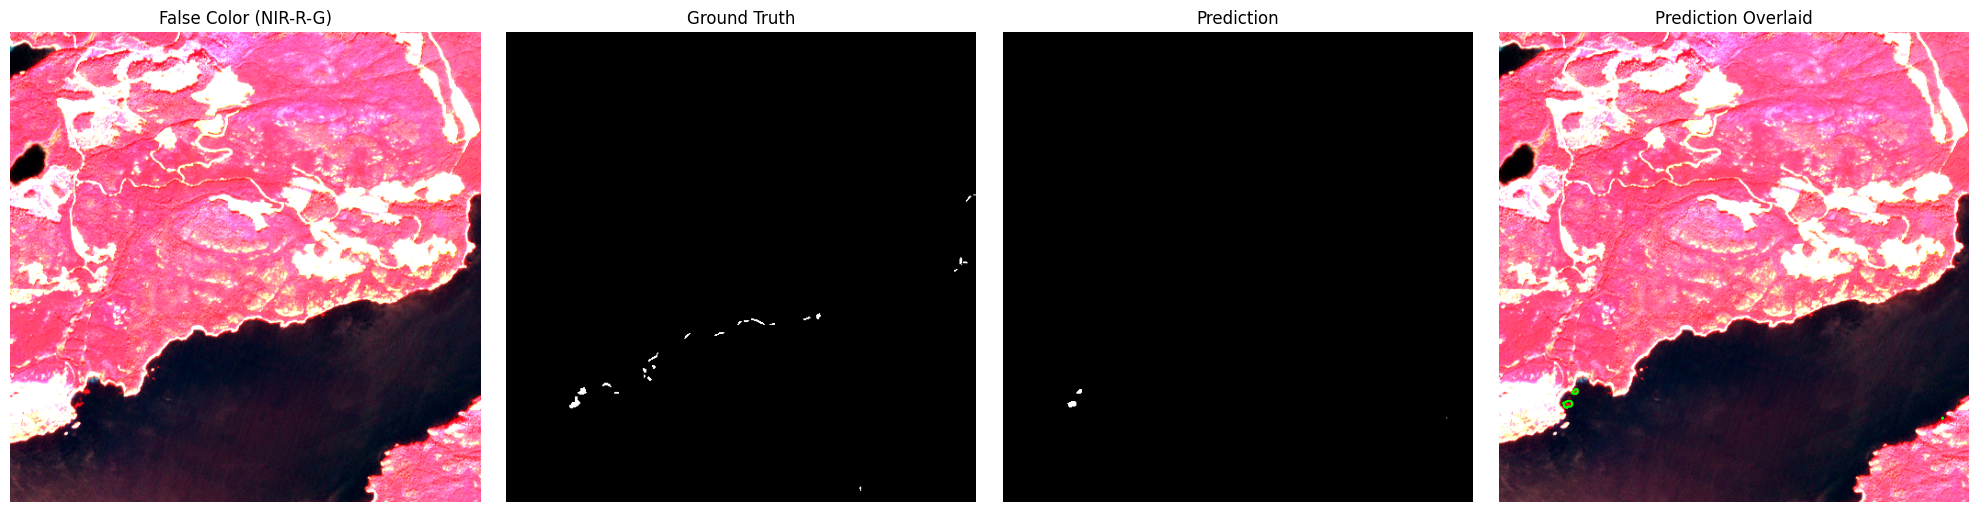

KeyboardInterrupt: 

In [10]:
def stretch_image(image, min_value=0, max_value=255):
    """Stretches the image channels based on conditions."""
    stretched = np.zeros_like(image, dtype=np.float32)
    cumulative_cuts = {
        0: (1, 45),  # Cumulative count cut for the first band (e.g., NIR)
        1: (2, 95),  # Cumulative count cut for the second band (e.g., Red)
        2: (2, 95)   # Cumulative count cut for the third band (e.g., Green)
    }
    
    # Default ranges for L1C data
    default_ranges = {
        0: {'min': 0, 'max': 200},  # NIR
        1: {'min': 0, 'max': 400},  # Red
        2: {'min': 0, 'max': 600}   # Green
    }
    
    for i in range(image.shape[2]):
        band = image[:, :, i]
        default_min = default_ranges[i]['min']
        default_max = default_ranges[i]['max']
        band_min = default_min
        band_max = default_max
        
        if np.all(band >= default_max) or np.all(band <= default_min):
            # All values outside default range, using cumulative cut
            lower_percentile, upper_percentile = cumulative_cuts[i]
            band_min = np.percentile(band, lower_percentile)
            band_max = np.percentile(band, upper_percentile)
        
        # Clip values before scaling
        band_clipped = np.clip(band, band_min, band_max)
        
        # Scale to min_value-max_value range
        stretched[:, :, i] = ((band_clipped - band_min) / (band_max - band_min) * (max_value - min_value)) + min_value
    
    # Convert to uint8 for display
    return stretched.astype(np.uint8)

# Create unnormalized dataset for visualization
visualize_test_dataset = KelpDataset(
    data_paths=list(zip(X_test_paths, y_test_paths)),
    normalization_params={'mean': [0, 0, 0, 0, 0], 'std': [1, 1, 1, 1, 1]},  # No normalization
    target_size=TARGET_SIZE,
    augment=False
)

visualize_test_loader = DataLoader(
    visualize_test_dataset, 
    batch_size=15, 
    shuffle=False,
    num_workers=NUM_WORKERS, 
    pin_memory=True, 
    persistent_workers=True
)

batch_vis = next(iter(visualize_test_loader))
    
# Get first batch for visualization
images_vis = batch_vis["pixels"]

# images_vis, _ = next(iter(visualize_test_loader))
batch = next(iter(test_loader))
images_norm = batch["pixels"]
masks = batch["label"]

with torch.no_grad():
    model.eval()
    logits = model({k: v.to(device) for k, v in next(iter(test_loader)).items()})

prob_masks = torch.sigmoid(logits.squeeze(1))
pr_masks = (prob_masks > THRESHOLD).float()

# Move back to CPU for visualization
masks = masks.cpu()
pr_masks = pr_masks.cpu()

print(f"Visualizing first {min(9, len(images_vis))} test samples...")

for idx, (image, gt_mask, pr_mask) in enumerate(zip(images_vis, masks, pr_masks)):
    if idx <= 8:
        plt.figure(figsize=(20, 5))  # 4 columns



        # Convert tensor to numpy
        image_np = image.cpu().numpy()  # [C, H, W]

        # Create false-color NIR-R-G image (bands: B2, B3, B4, B8, B5)
        nir = image_np[3, :, :]  # NIR band (B8, index 3)
        red = image_np[2, :, :]  # Red band (B4, index 2)
        green = image_np[1, :, :] # Green band (B3, index 1)
        rgb_image = np.stack([nir, red, green], axis=-1)  # [H, W, 3]

        # Apply stretch_image (assumes it returns uint8 or [0, 255] range)
        stretched_rgb = stretch_image(rgb_image)

        
        # 1. RGB image
        plt.subplot(1, 4, 1)
        plt.imshow(stretched_rgb)
        plt.title("False Color (NIR-R-G)")
        plt.axis("off")
        
        # 2. Ground truth mask
        plt.subplot(1, 4, 2)
        plt.imshow(gt_mask.numpy().squeeze(), cmap="gray")
        plt.title("Ground Truth")
        plt.axis("off")
        
        # 3. Prediction mask
        plt.subplot(1, 4, 3)
        plt.imshow(pr_mask.numpy().squeeze(), cmap="gray")
        plt.title("Prediction")
        plt.axis("off")
        
        # 4. Overlay predicted boundaries on RGB
        plt.subplot(1, 4, 4)
        plt.imshow(stretched_rgb)
        plt.title("Prediction Overlaid")
        plt.axis("off")
        
        # Vectorize the prediction mask
        contours = measure.find_contours(pr_mask.numpy().squeeze(), level=0.5)
        
        # Overlay contours
        for contour in contours:
            plt.plot(contour[:, 1], contour[:, 0], color='lime', linewidth=1.5)
        
        plt.tight_layout()
        plt.show()
    else:
        break


### Export Images as PNGs


In [ ]:
# Output directory for saving visualizations
OUTPUT_DIR = r"C:\Users\mohsenghanbari\saved_models\AnnotatedData\LeaveOneOutRev\clay"
os.makedirs(OUTPUT_DIR, exist_ok=True)
# Create unnormalized dataset for saving
visualize_test_dataset = KelpDataset(
    data_paths=list(zip(X_test_paths, y_test_paths)),
    normalization_params={'mean': [0, 0, 0, 0, 0], 'std': [1, 1, 1, 1, 1]},  # No normalization
    target_size=TARGET_SIZE,
    augment=False
)

visualize_test_loader = DataLoader(
    visualize_test_dataset, 
    batch_size=8, 
    shuffle=False, 
    num_workers=NUM_WORKERS, 
    pin_memory=True, 
    persistent_workers=True
)

# Loop through both test_loader and visualize_test_loader in parallel
print("Saving PNG images...")

for batch_idx, (batch, vis_batch) in enumerate(zip(test_loader, visualize_test_loader)):
    images = batch["pixels"] # Normalized images for model evaluation
    masks = batch["label"]
    vis_images = vis_batch["pixels"]  # Unnormalized images for visualization
    
    with torch.no_grad():
        model.eval()
        # Move normalized batch to device for inference
        batch_device = {k: v.to(device) for k, v in batch.items()}
        logits = model(batch_device)
    
    prob_masks = torch.sigmoid(logits.squeeze(1))
    pr_masks = (prob_masks > THRESHOLD).float()
    
    for idx, (vis_image, gt_mask, pr_mask) in enumerate(zip(vis_images, masks, pr_masks)):
        # Convert tensors to numpy arrays
        image_np = vis_image.cpu().numpy()  # Use unnormalized image
        gt_mask_np = np.squeeze(gt_mask.cpu().numpy()).astype(np.uint8)
        pr_mask_np = np.squeeze(pr_mask.cpu().numpy()).astype(np.uint8)
        
        # Define filenames for PNG images
        false_color_filename = os.path.join(OUTPUT_DIR, f'{batch_idx}_{idx}_false_color.png')
        gt_overlay_filename = os.path.join(OUTPUT_DIR, f'{batch_idx}_{idx}_ground_truth.png')
        pred_overlay_filename = os.path.join(OUTPUT_DIR, f'{batch_idx}_{idx}_prediction.png')
        
        # Create false-color NIR-R-G image (bands: B2, B3, B4, B8, B5)
        nir = image_np[3, :, :]  # NIR band (B8, index 3)
        red = image_np[2, :, :]  # Red band (B4, index 2)
        green = image_np[1, :, :] # Green band (B3, index 1)
        
        # Stack bands into [height, width, 3] for stretch_image
        false_color_input = np.stack([nir, red, green], axis=2)
        
        # Apply stretch_image to create false-color image
        false_color = stretch_image(false_color_input)
        
        # Save false-color image as PNG
        Image.fromarray(false_color).save(false_color_filename)
        
        # Create ground truth overlay (kelp pixels in lime)
        gt_overlay = false_color.copy()
        kelp_pixels_gt = gt_mask_np == 1
        gt_overlay[kelp_pixels_gt] = [0, 255, 0]  # Lime for ground truth
        
        # Save ground truth overlay as PNG
        Image.fromarray(gt_overlay).save(gt_overlay_filename)
        
        # Create prediction overlay (kelp pixels in yellow)
        pred_overlay = false_color.copy()
        kelp_pixels_pred = pr_mask_np == 1
        pred_overlay[kelp_pixels_pred] = [255, 255, 0]  # Yellow for prediction
        
        # Save prediction overlay as PNG
        Image.fromarray(pred_overlay).save(pred_overlay_filename)
        
        print(f'Saved {false_color_filename}, {gt_overlay_filename}, and {pred_overlay_filename}')

print(f"All images saved to {OUTPUT_DIR}")